In [1]:
import yaml
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 20)

from bs4 import BeautifulSoup
from collections import Counter
from concurrent import futures
from itertools import combinations, chain, permutations, product
import json
import networkx as nx
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist
from urllib.parse import urlparse
import datetime

import comment_thread as ct
import author_network as an
import multi_comment_thread as mct

In [2]:
SBSTYLE = 'seaborn-talk'

In [3]:
def process_polymath(project, split=False):
    message = "Polymath {}".format(project.split(" ")[-1]) if project.startswith("pm") else "Mini Polymath {}".format(project[-1])
    
    pm_frame = DataFrame(list(ct.main(project, use_cached=False, cache_it=False, merge=False).items()),
                         columns=["title", "thread"])
    pm_frame['url'] = pm_frame['thread'].apply(lambda thread: thread.url)
    pm_frame['research'] = pm_frame['thread'].apply(lambda thread: thread.is_research)
    pm_frame['blog'] = pm_frame['thread'].apply(lambda thread: thread.thread_url.netloc.split('.')[0].title())
    pm_frame['number of comments'] = pm_frame['thread'].apply(lambda x: len(x.node_name.keys()))
    pm_frame['number of comments (accumulated)'] = pm_frame['number of comments'].cumsum()
        
    indices = pm_frame.index
    threads = pm_frame.thread
    pm_frame['mthread (single)'] = pm_frame['thread'].apply(mct.MultiCommentThread)
    pm_frame['mthread (accumulated)'] = Series([mct.MultiCommentThread(*threads[0:i+1]) for i in indices],
                                               index=indices)
    pm_frame['network'] = pm_frame['mthread (accumulated)'].apply(an.AuthorNetwork)
    
    if split:
        r_indices = pm_frame[pm_frame['research']].index
        d_indices = pm_frame[~pm_frame['research']].index
        r_threads = pm_frame[pm_frame['research']].thread
        d_threads = pm_frame[~pm_frame['research']].thread
        pm_frame['r_mthread (accumulated)'] = Series([mct.MultiCommentThread(*r_threads[0:i+1]) for i in r_indices],
                                                 index=r_indices)
        pm_frame['d_mthread (accumulated)'] = Series([mct.MultiCommentThread(*d_threads[0:i+1]) for i in d_indices],
                                                 index=d_indices)
        pm_frame['r_network'] = pm_frame[pm_frame['research']]['r_mthread (accumulated)'].apply(an.AuthorNetwork)
        pm_frame['d_network'] = pm_frame[~pm_frame['research']]['d_mthread (accumulated)'].apply(an.AuthorNetwork)
        pm_frame = pm_frame.reindex_axis(['title', 'url', 'blog', 'research',
                                          'number of comments', 'number of comments (accumulated)',
                                          'thread', 'mthread (single)',
                                          'mthread (accumulated)', 'network',
                                          'r_mthread (accumulated)', 'r_network',
                                          'd_mthread (accumulated)', 'd_network'],
                                         axis=1)
    else:
        pm_frame = pm_frame.reindex_axis(['title', 'url', 'blog', 'research', 'number of comments',
                                      'thread', 'mthread (single)',
                                      'mthread (accumulated)', 'network'],
                                     axis=1)

    pm_frame.index = pd.MultiIndex.from_tuples([(message, i) for i in indices],
                                               names=['Project', 'Ord'])
    
    return pm_frame

In [4]:
PM1_FRAME = process_polymath("pm 1", split=True)
PM2_FRAME = process_polymath("pm 2", split=True)
PM3_FRAME = process_polymath("pm 3", split=True)
PM4_FRAME = process_polymath("pm 4", split=True)
PM5_FRAME = process_polymath("pm 5", split=True)
PM6_FRAME = process_polymath("pm 6", split=True)
PM7_FRAME = process_polymath("pm 7", split=True)
PM8_FRAME = process_polymath("pm 8", split=True)
PM9_FRAME = process_polymath("pm 9", split=True)
PM10_FRAME = process_polymath("pm 10", split=True)
PM11_FRAME = process_polymath("pm 11", split=True)

In [5]:
POLYMATHS = [PM1_FRAME, PM2_FRAME, PM3_FRAME, PM4_FRAME, PM5_FRAME, PM6_FRAME, PM7_FRAME, PM8_FRAME, PM9_FRAME, PM10_FRAME, PM11_FRAME]
COL_ORDER = PM1_FRAME.columns.tolist()
PM_FRAME = pd.concat(POLYMATHS)[COL_ORDER]

In [6]:
PM_FRAME['authors'] = PM_FRAME['thread'].apply(lambda thread: thread.authors)
PM_FRAME['authors (accumulated)'] = PM_FRAME['network'].apply(lambda network: set(network.author_frame.index))
PM_FRAME['comment_counter'] = PM_FRAME['mthread (single)'].apply(lambda mthread: Counter(mthread.node_name.values()))
PM_FRAME['comment_counter (accumulated)'] = PM_FRAME['mthread (accumulated)'].apply(lambda mthread: Counter(mthread.node_name.values()))

In [7]:
ALL_AUTHORS = set.union(*PM_FRAME['authors'].tolist())

# Modelling Online Collaborative Mathematics
### Patrick Allo
#### Oxford Internet Institute

## The Plan

+ Some background on the *Polymath Projects* and their place in the literature.
+ The goal of this talk.
+ Online research: methodology and general insights.
+ Formal models of scientific communities.
+ The role of higher-order information for collaboration.
+ Extracting patterns of interaction from the data.
+ Roles in the collaboration.
+ Conclusion: Central figures as available active aggregators.

## The Polymath Projects
### *I’m interested in the question of whether it is possible for lots of people to solve one single problem rather than lots of people to solve one problem each*

+ Open collaborative mathematics project initiated by Timothy Gowers in Februari 2009.
+ Polymath 1 was devoted to the task of finding an elementary proof of the *Density Hales-Jewett Theorem*.
+ Terence Tao soon joined Gowers as one of the leading figures.
+ Probable success was announced less than 6 weeks after the start of the project.
+ Results were published under the name "D.H.J. Polymath".
+ Still active: Polymath 10 and 11 started in the last 6 months.

## Disciplinary perspectives
+ Philosophy of mathematical practices: Real mathematics in action.
+ Social studies of the internet: e-research and citizen science.
+ Social epistemology: structure of scientific communities.

## Existing literature
+ **By insiders** Gowers & Nielsen. 2009. Massively collaborative mathematics. *Nature* 46. Michael Nielsen. "Reinventing discovery : the new era of networked science".
+ **Popular science** New Scientist: “Mathematics becomes more sociable”, “How to build the global mathematics brain”.
+ **Quantitative and social network analysis** of Polymath 1 by Cranshaw & Kittur (2011).
+ Studied within the **"Social Machine of Mathematics"** project by Pease and Martin.
+ More publications by: Varshney (2012), Stefaneas & Vandoulakis (2012).
+ Van Bendegem, J.P., 2014, Logic, Methodology and Philosophy of Science. Proceedings of the 14th International Congress (Nancy). Logic and Science Facing the New Technologies, Mathematics and the new technologies, part III: The cloud and the web of proofs. College Publications,  London, pp. 427-39.
+ Allo, P., Bendegem, J.P.V. & Kerkhove, B.V. 2013, Mathematical Arguments and Distributed Knowledge, in Aberdein & Dove (eds), The Argument of Mathematics, Springer Netherlands, Dordrecht, pp. 339-60.

## What I want to do
+ Go beyond the retelling of the story of Polymath.
+ Evaluate whether this is really *a new kind of mathematics*.
+ Focus on division of epistemic labour, information-flow, community-structures and diversity of roles.
+ Use this as a case-study in the study of the structure of scientific communities.

### What I will leave aside
+ The role of ICT in mathematical research.
+ Polymath as e-research or as citizen science.
+ Quantitative insights.
+ Substantial network-analysis (e.g. compute centrality-measures and triadic closure, look for connected components, ...).
+ The messy details of cleaning the data, and some of the obstacles I faced.

### Methodological aims
+ Rely on how formal methods can be used to study scientific communities, interaction, and information-flow.
+ Not as a-priori methods, but as a source of concepts to guide an empirical study.

## What I did

### From a nested discussion to a tree of comments

#### A toy-example

+ Blog-post (L0-comment)
    + L1-comment: *timestamp: ..., author: Alice, content: ..., ...*
    + L1-comment: *timestamp: ..., author: Bob, content: ..., ...*
        + L2-comment: *timestamp: ..., author: Alice, content: ..., ...*
        + L2-comment: *timestamp: ..., author: Carol, content: ..., ...*
    + L1-comment: *timestamp: ..., author: Bob, content: ..., ...*
        + L2-sub-comment: *timestamp: ..., author: Alice, content: ..., ...*
            + L3-comment: *timestamp: ..., author: Bob, content: ..., ...*

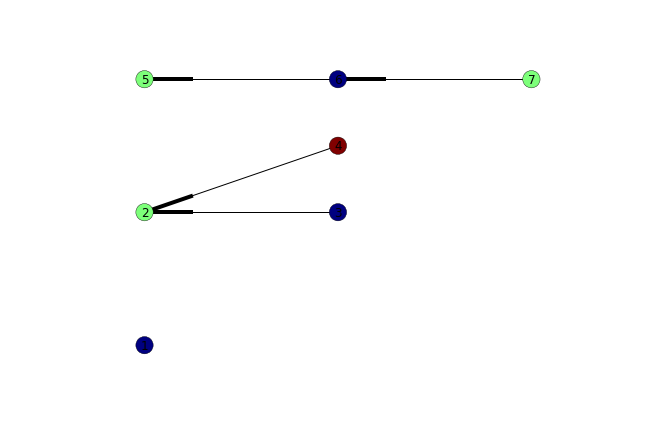

In [8]:
example_graph = nx.DiGraph()
example_graph.add_nodes_from([1,2,3,4,5,6,7])
example_graph.add_edges_from([(3,2), (4,2), (6,5), (7,6)])
matplotlib.style.use(SBSTYLE)
nx.draw_networkx(example_graph, pos={1: (0,0), 2: (0,1), 3: (1,1), 4: (1, 1.5), 5: (0, 2), 6: (1, 2), 7: (2,2)},
                 node_list=[1,2,3,4,5,6,7],
                node_color=[1, 2, 1, 3, 2, 1,2])
limits=plt.axis("off")

+ Blog-post is not included.
+ Edges from child-node to parent-node.
+ Level of comment = distance to blog-post.
+ A project is a list of threads.

### To an interaction-network 

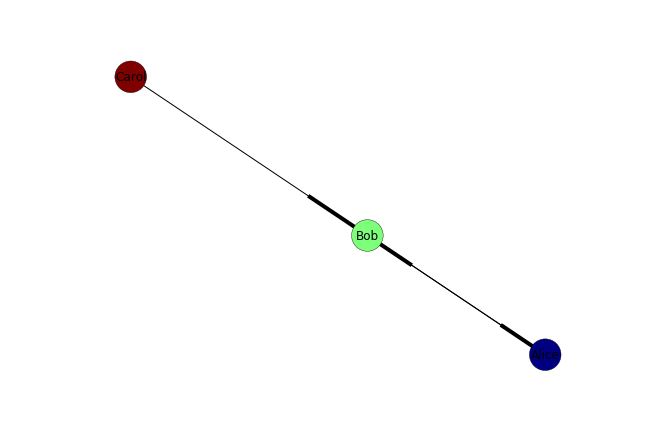

In [9]:
example_graph2 = nx.DiGraph()
example_graph2.add_nodes_from(['Alice', 'Bob', 'Carol'])
example_graph2.add_weighted_edges_from([('Alice', 'Bob', 2), ('Bob', 'Alice', 1), ('Carol', 'Bob', 1)])
matplotlib.style.use(SBSTYLE)
nx.draw_networkx(example_graph2, node_list=['Alice', 'Bob', 'Carol'], node_color=[1,3,2], node_size=1000)
limits=plt.axis("off")

### And associated meta-data for each author
+ Total number of comments
+ Number of comments by comment-level.
+ Total word-count.
+ Timestamps of all comments.

## A General Overview of Polymath

+ **Polymath1:** New proofs and bounds for the density Hales-Jewett theorem. Initiated Feb 1, 2009; research results have now been <span style="color:red">published<span>.
+ **Polymath2:** Must an “explicitly defined” Banach space contain $c_0$ or $l_p$? Initiated Feb 17, 2009; attempts to relaunch via wiki, June 9 2010.
+ **Polymath3:** The polynomial Hirsch conjecture. Proposed July 17, 2009; launched, September 30, 2010.
+ **Polymath4:** A deterministic way to find primes. Proposed July 27, 2009; launched Aug 9, 2009. Research results have now been <span style="color:red">published<span>.
+ **Polymath5:** The Erdős discrepancy problem. Proposed Jan 10, 2010; launched Jan 19, 2010. Activity ceased by the end of 2012, but <span style="color:red">results from the project were used to solve the problem in 2015</span>.
+ **Polymath6:** Improving the bounds for Roth's theorem. Proposed Feb 5, 2011. <span style="color:red">Partial result published by non-participant</span>
+ **Polymath7:** Establishing the Hot Spots conjecture for acute-angled triangles. Proposed, May 31st, 2012; launched, Jun 8, 2012.
+ **Polymath8:** Improving the bounds for small gaps between primes. Proposed, June 4, 2013; launched, June 4, 2013. Research results have now been <span style="color:red">published<span>.
+ **Polymath9:** exploring Borel determinacy-based methods for giving complexity bounds. Proposed, Oct 24, 2013; launched, Nov 3, 2013. <span style="color:red">“success of a kind”<span>.
+ **Polymath10:** improving the bounds for the Erdos-Rado sunflower lemma. Launched, Nov 2, 2015. <span style="color:red">ongoing</span>
+ **Polymath11:** proving Frankl's union-closed conjecture. Proposed Jan 21, 2016; launched Jan 29, 2016. <span style="color:red">ongoing</span>

### Sizes of the projects

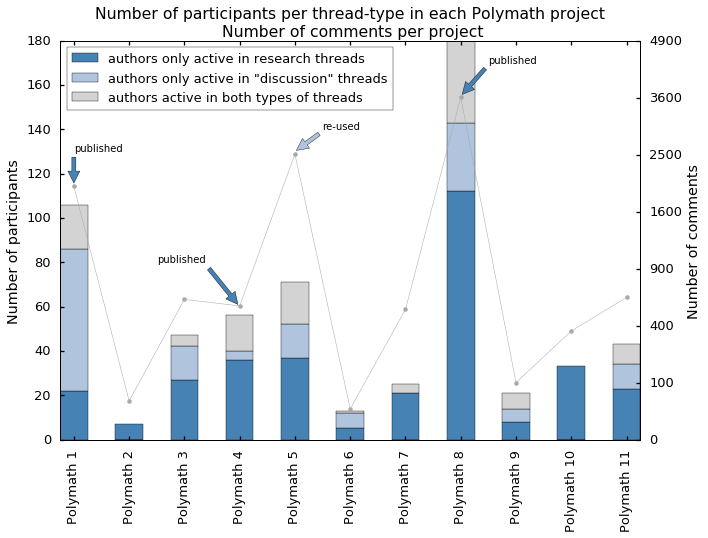

In [10]:
from matplotlib.ticker import FuncFormatter

PROJECTS_TO_C = ["Polymath {}".format(i) for i in range(1, 12)] 
PARTICIPANTS = Series([PM_FRAME.loc[project]['authors (accumulated)'].iloc[-1] for
                project in PROJECTS_TO_C], index=PROJECTS_TO_C)
R_NETWORKS = Series([PM_FRAME.loc[project]['r_network'].dropna().iloc[-1] for project in PROJECTS_TO_C],
                    index=PROJECTS_TO_C)
WITH_D = [project for project in PROJECTS_TO_C if not PM_FRAME.loc[project]['research'].all()]
D_NETWORKS = Series([PM_FRAME.loc[project]['d_network'].dropna().iloc[-1] for project in WITH_D],
                    index=WITH_D)
R_PARTICIPANTS = R_NETWORKS.apply(lambda network: set(network.author_frame.index))
D_PARTICIPANTS = D_NETWORKS.apply(lambda network: set(network.author_frame.index))
COMMENTS = Series([PM_FRAME.loc[project]['number of comments (accumulated)'].iloc[-1] for
                project in PROJECTS_TO_C], index=PROJECTS_TO_C)

df = DataFrame({'all threads': PARTICIPANTS, 'research threads': R_PARTICIPANTS, 'discussion threads': D_PARTICIPANTS},
              index=PROJECTS_TO_C)
df['authors only active in research threads'] = df['research threads'] - df['discussion threads']
df['authors only active in "discussion" threads'] = df['discussion threads'] - df['research threads']
df['authors active in both types of threads'] = df['all threads'] - df['authors only active in research threads'] - df['authors only active in "discussion" threads']
for project in PROJECTS_TO_C:
    if pd.isnull(df.loc[project]['authors only active in research threads']):
        df.loc[project]['authors only active in research threads'] = df.loc[project]['all threads']
data = df[['authors only active in research threads', 'authors only active in "discussion" threads', 'authors active in both types of threads']]
data = data.applymap(lambda set: len(set) if pd.notnull(set) else 0)
matplotlib.style.use(SBSTYLE)
axes = data.plot(kind='bar', stacked=True, color=['steelblue', 'lightsteelblue', 'lightgrey'],
          title="Number of participants per thread-type in each Polymath project\n Number of comments per project")
axes.set_ylabel("Number of participants")
axes.annotate('published', xy=(0, 115), xytext=(0, 130),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
axes.annotate('published', xy=(3, 60), xytext=(1.5, 80),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
axes.annotate('re-used', xy=(4, 130), xytext=(4.5, 140),
            arrowprops=dict(facecolor='lightsteelblue', shrink=0.05),
            )
axes.annotate('published', xy=(7, 155), xytext=(7.5, 170),
            arrowprops=dict(facecolor='steelblue', shrink=0.05),
            )
data2 = np.sqrt(COMMENTS)
axes2 = axes.twinx()
axes2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos:"{:0.0f}".format(np.square(x))))
axes2.set_ylabel("Number of comments")
axes2.plot(axes.get_xticks(), data2.values,
                   linestyle='-', marker='.', linewidth=.5,
                   color='darkgrey')

In [11]:
def get_last(lst_of_frames):
    if lst_of_frames == POLYMATHS:
        source = PM_FRAME
        positions = np.array([frame.index.levels[1][-1] for frame in lst_of_frames]).cumsum() + np.arange(len(POLYMATHS))
    elif lst_of_frames == MINIPOLYMATHS:
        source = mPM_FRAME
        positions = np.array([frame.index.levels[1][-1] for frame in lst_of_frames]).cumsum() + np.arange(len(MINIPOLYMATHS))
    else:
        raise ValueError("Need either POLYMATHS or MINIPOLYMATHS")
    source.index = source.index.swaplevel(0,1)
    data = source.iloc[positions]
    source.index = source.index.swaplevel(1,0)
    data.index = data.index.droplevel()
    return data, positions

In [12]:
def plot_community_evolution(project):
    if isinstance(project.split()[-1], int):
        as_threads = True
        data = mPM_FRAME.loc[project] if project.startswith("Mini") else PM_FRAME.loc[project]
        added = (data['authors'] - data['authors'].shift(1)).apply(lambda x: 0 if isinstance(x, float) else len(x))
        removed = (data['authors'].shift(1) - data['authors']).apply(lambda x: 0 if isinstance(x, float) else - len(x))
        size = data['authors'].apply(len) - added
        df = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                       columns=["joined", "current", "left"], index=data.index)
        df.index.name = "Threads"
    else:
        as_threads = False
        if project.startswith("Mini"):
            data, positions = get_last(MINIPOLYMATHS)
        elif project.startswith("Poly"):
            data, positions = get_last(POLYMATHS)
        else:
            raise ValueError("Need either Polymath or Mini Polymath")
        added = (data['authors (accumulated)'] - data['authors (accumulated)'].shift(1)).apply(lambda x: 0 if isinstance(x, float) else len(x))
        removed = (data['authors (accumulated)'].shift(1) - data['authors (accumulated)']).apply(lambda x: 0 if isinstance(x, float) else - len(x))
        size = data['authors (accumulated)'].apply(len) - added
        df = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                       columns=["joined", "current", "left"])
        df.index = list(range(1, len(positions) + 1))
    
    matplotlib.style.use(SBSTYLE)
    fig = plt.figure()
    axes = df.plot(kind="area", title="Community Evolution in {}".format(project),
            color=['sage', 'lightgrey', 'indianred'], stacked=True)
    axes.set_xticks(df.index)
    if as_threads:
        axes.set_xticklabels(data['title'], rotation=90, fontsize='small')
    else:
        xlabels = sorted(data.index, key=lambda x: int(x.split()[-1]))
        axes.set_xticklabels(xlabels, rotation=90, fontsize='small')
    axes.set_ylabel('number of active commenters')




### Size and evolution of the community

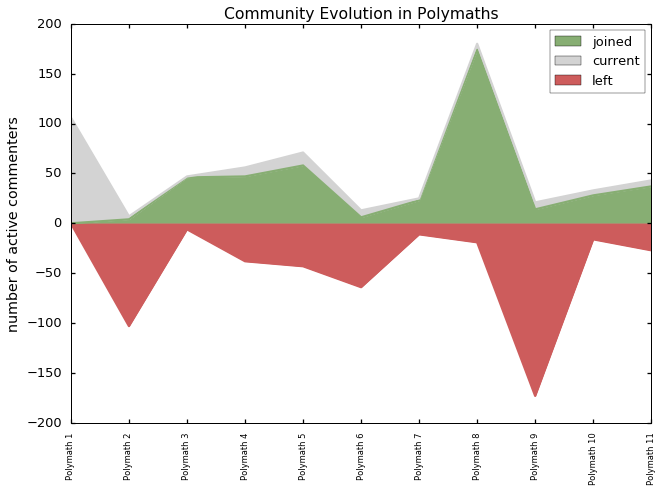

In [13]:
plot_community_evolution("Polymaths")

In [14]:
def plot_participation_evolution(project, n=2, skip_anon=True, fontsize=8):
    if project.split()[-1]in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']:
        print("process threads")
        as_threads = True
        if project.startswith("Mini"):
            data = mPM_FRAME.loc[project]
        elif project.startswith("Poly"):
            data = PM_FRAME.loc[project]
        else:
            raise ValueError("Need either Polymath or Mini Polymath project")
        all_authors = data.iloc[-1]['authors (accumulated)']
        data = data['authors']
        title = "Participation per thread in {} (threshold = {})".format(project, n)
    else:
        as_threads = False
        if project.startswith("Mini"):
            data, positions = get_last(MINIPOLYMATHS)
            all_authors = list(ALL_MINI_AUTHORS)
            title = "Participation per project in Polymath (threshold = {})".format(n)
        elif project.startswith("Poly"):
            data, positions = get_last(POLYMATHS)
            all_authors = list(ALL_AUTHORS)
            title = "Participation per project in Polymath (threshold = {})".format(n)
        else:
            raise ValueError("Need either Polymath or Mini Polymath")
        data = data['authors (accumulated)']
    indices = data.index.tolist()
    author_project = DataFrame(index=all_authors)
    for ind in indices:
        author_project[ind] = np.zeros_like(author_project.index, dtype=bool)
        for author in data[ind]:
            author_project[ind][author] = True
    author_project = author_project.sort_values(by=indices, ascending=False)
    author_project = author_project.drop("Anonymous") if skip_anon else author_project
    select = author_project.sum(axis=1) >= n
    matplotlib.style.use(SBSTYLE)
    factor = 30 - len(indices) if len(indices) <= 30 else 40 - len(indices)
    colors = [plt.cm.Set1(factor*i) for i in range(len(indices))]
    author_project.loc[select].plot(kind="bar", stacked=True, color=colors,
                                    title=title, fontsize=fontsize)
    return select

### Importance of “early adopters”

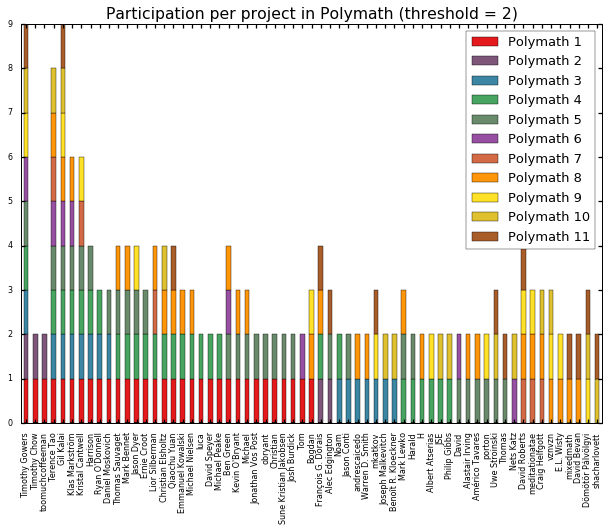

In [15]:
select_n = plot_participation_evolution("Polymath", n=2)

### The global Polymath community structure

(threshold: participation to at least two projects)

Cophenetic Correlation Coefficient with ward: 0.9424851136308227


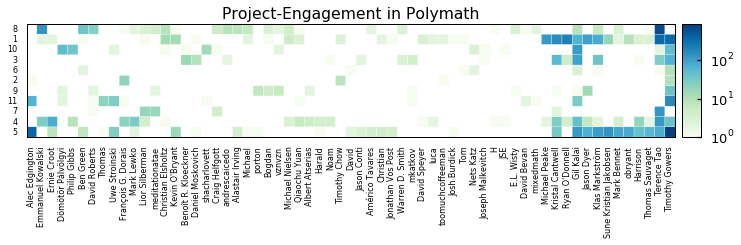

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

authors_n = sorted([author for author, bool in select_n.items() if bool])

def general_heatmap(authors=None, binary=False, thread_level=True,
                    binary_method='average', method='ward', log=True,
                    fontsize=8): 
    if thread_level:
        authors_filtered = list(ALL_AUTHORS)
        try:
            authors_filtered.remove("Anonymous")
        except:
            pass
        data=PM_FRAME['comment_counter']
    else:
        authors_filtered = list(ALL_AUTHORS) if not authors else authors 
        try:
            authors_filtered.remove("Anonymous")
        except:
            pass
        data = get_last(POLYMATHS)[0]['comment_counter (accumulated)']
    if binary:
        as_matrix=np.array([[True if author in data[thread] else False for author in authors_filtered]
                        for thread in data.index])
        Z_author = linkage(as_matrix.T, method=binary_method, metric='hamming')
        Z_thread = linkage(as_matrix, method=binary_method, metric='hamming')
        c, _ = cophenet(Z_author, pdist(as_matrix.T))
        print("Cophenetic Correlation Coefficient with {}: {}".format(binary_method, c))
    else:
        as_matrix = []
        for thread in data.index:
            new_row = [data.loc[thread][author] for author in authors_filtered]
            as_matrix.append(new_row)
        as_matrix = np.array(as_matrix)
        Z_author = linkage(as_matrix.T, method=method, metric='euclidean')
        Z_thread = linkage(as_matrix, method=method, metric='euclidean')
        c, _ = cophenet(Z_author, pdist(as_matrix.T))
        print("Cophenetic Correlation Coefficient with {}: {}".format(method, c))
    # start setting up plots
    matplotlib.style.use(SBSTYLE)
    fig, ax_heatmap = plt.subplots()
    # compute and plot dendogram (top-plot)
    ddata_author = dendrogram(Z_author, color_threshold=.07,
                              no_plot=True)
    ddata_thread = dendrogram(Z_thread, color_threshold=.07, no_plot=True)
    df = DataFrame(as_matrix, columns=authors_filtered)
    cols = [authors_filtered[i] for i in ddata_author['leaves']]
    df = df[cols]
    rows = [df.index[i] for i in ddata_thread['leaves']]
    df = df.reindex(rows)
    # plot heatmap (bottom)
    heatmap = ax_heatmap.pcolor(df,
                        edgecolors='w',
                        cmap=mpl.cm.binary if binary else mpl.cm.GnBu,
                        norm=mpl.colors.LogNorm() if log else None)
    
    ax_heatmap.autoscale(tight=True)  # get rid of whitespace in margins of heatmap
    ax_heatmap.set_aspect('equal')  # ensure heatmap cells are square
    ax_heatmap.xaxis.set_ticks_position('bottom')  # put column labels at the bottom
    ax_heatmap.tick_params(bottom='off', top='off', left='off', right='off')  # turn off ticks
    ax_heatmap.set_title("Project-Engagement in Polymath")
    
    ax_heatmap.set_yticks(np.arange(0.5, len(df.index)+.5, 1))
    ax_heatmap.set_yticklabels(df.index + 1, fontsize=fontsize)
    ax_heatmap.set_xticks(np.arange(len(df.columns)) + 0.5)
    ax_heatmap.set_xticklabels(df.columns, rotation=90, fontsize=fontsize)
    
    if not binary:
        divider_h = make_axes_locatable(ax_heatmap)
        cax = divider_h.append_axes("right", "3%", pad="1%")
        plt.colorbar(heatmap, cax=cax)
        
    lines = (ax_heatmap.xaxis.get_ticklines() +
             ax_heatmap.yaxis.get_ticklines())
    plt.setp(lines, visible=False)
    
    plt.tight_layout()

general_heatmap(authors=authors_n, thread_level=False, 
                binary=False, log=True)

### A natural grouping based on similarity
+ **Leaders (2):** Tao & Gowers
+ **Core-participants (11):** Peake -> Sauvaget
+ **Periphery (49):** Kowalski -> mixedmath
+ **Outsider (1):** Edgington (very active in PM5 and PM11, but not an early adopter)

### The strange case of Polymath 8
+ Most comments and most participants.
+ Little commenting activity in the heatmap.
+ Only 29 of the 180 participants to Polymath 8 overlap with other projects.
+ Typical computational project: “a project to improve the bound $H=H_1$ on the least gap between consecutive primes that was attained infinitely often”

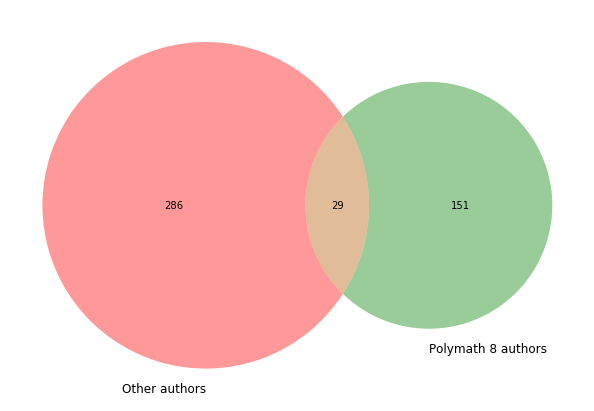

In [17]:
test_data, _ = get_last(POLYMATHS)
the_authors = test_data['authors (accumulated)']
pm8_authors = the_authors['Polymath 8']
other_authors = the_authors.iloc[[0,1,2,3,4,5,6,8,9,10]]
other_authors = set.union(*other_authors.values)
from matplotlib_venn import venn2

venn2([other_authors, pm8_authors], set_labels=['Other authors', 'Polymath 8 authors'])


## The *economic model*

### What is the optimal structure of communication (given certain assumptions) for a given epistemic aim?

+ Bala & Goyal model adapted by Zollman.

+ Communities are represented as graphs.

+ Individual agents are Bayesian learners who observe other agents and try to improve on the basis of their observations.

+ Success = converging to the truth.

+ Results based on simulations (typically in netlog).

+ Widely cited insight: maximal connectivity is *not* the optimal organisation (being shielded from potentially bad information is beneficial).

+ Recently criticized by Rosenstock, O'Connor and Bruner: results not robust when parameters are modified. E.g. for >6 communities.

+ A-priori approach with no connection to actual scientific communities (cfr. Martini & Pinto on need to connect simulations with the data).

### Further assumptions

+ Only *factual information* is exchanged.

+ Agent-behaviour is reduced to choosing an option.

+ Graph-based typology of communities

+ Only one-to-one exchanges.

### Not readily applicable to Polymath

+ Does not fit the open-ended character of Polymath.

+ Interactions in Polymath cannot be reduced to observations.

+ Collaboration cannot be reduced to information-exchange between individual agents and individual success.

### Further challenge
+ Public character of Polymath suggests maximal accessibility.

## Teamwork and higher-order information

### Active collaboration relies on strong group-attitudes
+ Mutual intentions.
+ Common intentions.
+ Group commitments.

+ Higher-order attitudes, and common belief in particular are essential for teamwork (Dunin-Keplicz & Verbrugge 2010).

+ But common information, belief and knowledge require public announcements and hence a common informational context.

+ Public announcements exclude all ignorance regarding what was announced, and regarding the effect of the announcement itself.

+ Impossible to achive through asynchronous communication.

### Announcement-types as a typology for collaborative networks

+ Access to information does not explain why teamwork succeeds.
+ Reliable information-aggregation isn't sufficient for teamwork.
+ Patterns of one-to-many communication as a finer typology.

**Note:** Zollman's model could be seen as private announcements/observations only.

## Three perspectives on information-flow

### High-level co-presence
+ **Criterion:** participation in the same thread
+ **Account:** who might have interacted

In [18]:
def project_heatmap(project, binary=False, cluster_threads = True,
                    method='ward', binary_method='average',
                    skip_anon=True, log=False, fontsize=8):
    """
    Plots clustered heatmaps of thread-participation per author.
    Based on: https://gist.github.com/s-boardman/cef9675329a951e89e93
              https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    """
    if project.startswith("Mini"):
        data = mPM_FRAME.loc[project].copy()
    elif project.startswith("Poly"):
        data = PM_FRAME.loc[project].copy()
    else:
        raise ValueError("Need either Polymath or Mini Polymath project")
    all_authors = sorted(list(data.iloc[-1]['authors (accumulated)']))
    if skip_anon:
        try:
            all_authors.remove("Anonymous")
        except ValueError:
            pass
    data = data['comment_counter']
    title = "Participation per thread in " + project
    if binary:
        as_matrix=np.array([[True if author in data[thread] else False for author in all_authors]
                        for thread in data.index])
        Z_author = linkage(as_matrix.T, method=binary_method, metric='hamming')
        if cluster_threads:
            Z_thread = linkage(as_matrix, method=binary_method, metric='hamming')
        c, _ = cophenet(Z_author, pdist(as_matrix.T))
        #print("Cophenetic Correlation Coefficient with {}: {}".format(binary_method, c))
    else:
        as_matrix = []
        for thread in data.index:
            new_row = [data.loc[thread][author] for author in all_authors]
            as_matrix.append(new_row)
        as_matrix = np.array(as_matrix)
        Z_author = linkage(as_matrix.T, method=method, metric='euclidean')
        if cluster_threads:
            Z_thread = linkage(as_matrix, method=method, metric='euclidean')
        c, _ = cophenet(Z_author, pdist(as_matrix.T))
        #print("Cophenetic Correlation Coefficient with {}: {}".format(method, c))
    ddata_author = dendrogram(Z_author, color_threshold=10, no_plot=True)
    df = DataFrame(as_matrix, columns=all_authors)
    #cols = [all_authors[i] for i in ddata_author['leaves']]
    #df = df[cols]
    if cluster_threads:
        ddata_thread = dendrogram(Z_thread, color_threshold=.07, no_plot=True)
        rows = [df.index[i] for i in ddata_thread['leaves']]
        df = df.reindex(rows)
    matplotlib.style.use('seaborn-poster')
    fig, ax = plt.subplots(1,1)
    heatmap = ax.pcolor(df,
                        edgecolors='k' if binary else 'w',
                        cmap=mpl.cm.binary if binary else mpl.cm.GnBu,
                        norm=mpl.colors.LogNorm() if log else None)
    
    ax.autoscale(tight=True)  # get rid of whitespace in margins of heatmap
    ax.set_aspect('equal')  # ensure heatmap cells are square
    ax.xaxis.set_ticks_position('bottom')  # put column labels at the bottom
    ax.tick_params(bottom='off', top='off', left='off', right='off')  # turn off ticks
    ax.set_title("Thread-participation in {}".format(project))
    
    plt.yticks(np.arange(len(df.index)) + 0.5, df.index, fontsize=fontsize)
    plt.xticks(np.arange(len(df.columns)) + 0.5, df.columns, rotation=90, fontsize=fontsize)
    
    if not binary:
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", "3%", pad="1%")
        plt.colorbar(heatmap, cax=cax)
    
    plt.tight_layout()
            

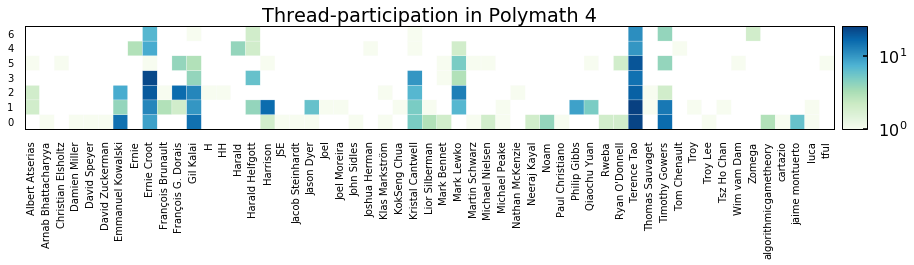

In [19]:
project_heatmap("Polymath 4", cluster_threads=True, method='average', log=True, fontsize=10)

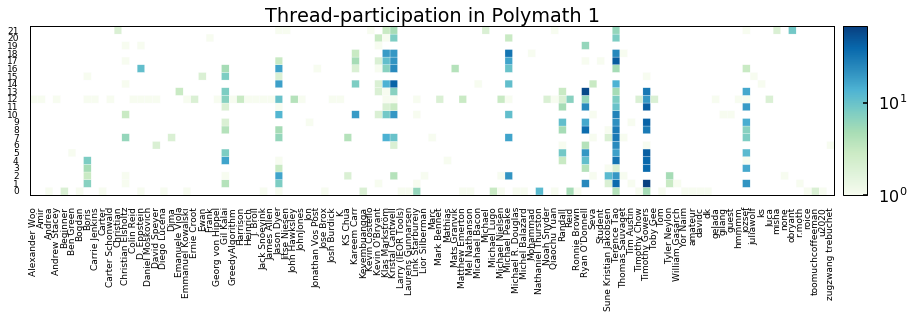

In [20]:
project_heatmap("Polymath 1", cluster_threads=False, method='average', log=True, fontsize=9)

### Direct Interaction
+ **Criterion:** direct replies
+ **Account:** who did interact

In [21]:
def get_project_at(project, stage):
    return mPM_FRAME.loc[project].iloc[stage] if project.startswith("Mini") else PM_FRAME.loc[project].iloc[stage]

def draw_network(project, graph_type, reset=False, stage=-1):
    """Wrapper function for author_network.draw_graph.
    Plots the interaction-network between the commenters in project."""
    get_project_at(project, stage)['network'].draw_graph(project=project, graph_type=graph_type, reset=reset)

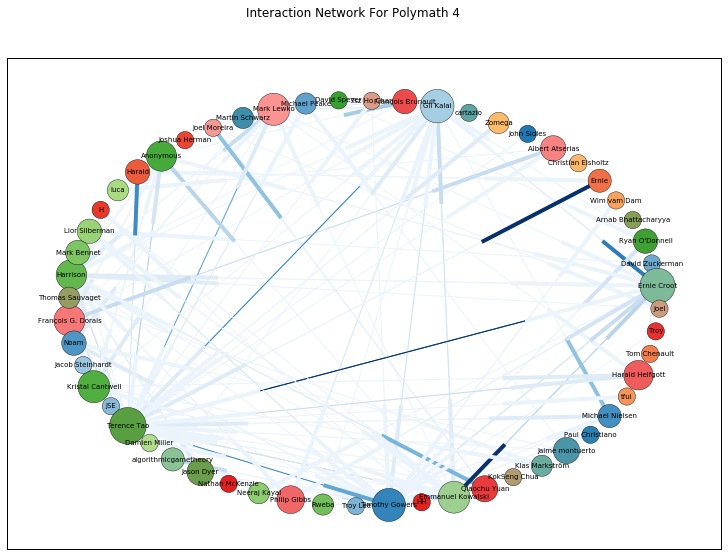

In [22]:
draw_network("Polymath 4", graph_type="interaction", reset=True)

+ Weighted directed graph.

### Finely grained co-presence
+ **Criterion:** high probability of mutual awareness
+ **Account:** who probably interacted

+ But how can this information be extracted from actual interactions?

## Proposal 1: Who's in the centre of discussion?

### The “centre of discussion” metaphor

+ Contributing puts one in the *centre of discussion*.

+ Closeness to the *centre of discussion* is an indication for availability.

+ Being close to the *centre of discussion* is sufficient to know who's also close to the centre of discussion.

+ The above is common knowledge.

+ Modulo vagueness (and abstracting from the temporal ordering) about what it means to be close to the centre of discussion, the set *A* of agents that are close to the centre of discussion is common knowledge within *A*.

+ This approximates the conditions for the members of *A* to make **public announcements** to the members of *A*.

+ Common knowledge within *A* of what is announced is highly probable. 

### Modelling assumption
+ Distance from the centre of discussion is proportional to time elapsed since last comment.

In [23]:
import io
import base64
from IPython.display import HTML

video = io.open('FIGS/out.m4v', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

### Proposal 2: Identify coherent episodes in discussion-threads

### Clustering of time-lines
+ Used `MeanShift` algorithm to identify clusters in lists of time-stamps.
+ Motivation: bursts of activity as proxy for episodes in a discussion-thread.

In [24]:
def plot_activity(project, color_by, first, last, intervals=1,
                  activity='thread', stage=-1):
    """Wrapper function for mthread.plot_activity
    Plots thread or author activity over time for project"""
    get_project_at(project, stage)['mthread (accumulated)'].plot_activity(activity, color_by,
                                                                          intervals=intervals,
                                                                          first=first,
                                                                          last=last,
                                                                          project=project)

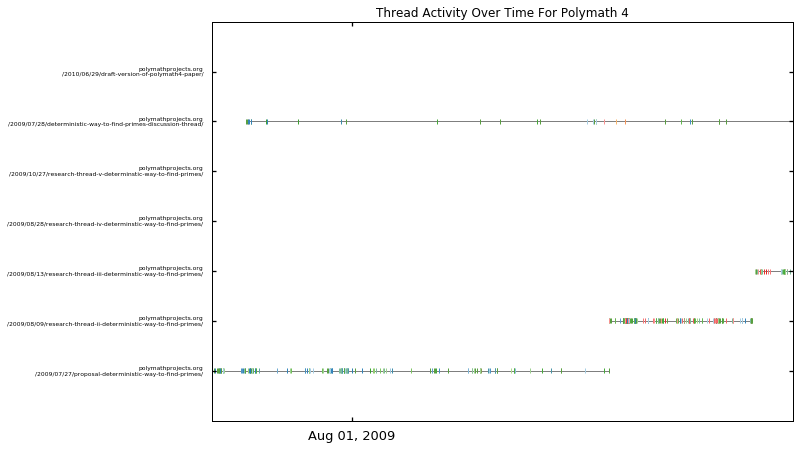

In [25]:
plot_activity("Polymath 4", color_by="author", first="2009-07-01", last="2009-08-15")

### Co-location network

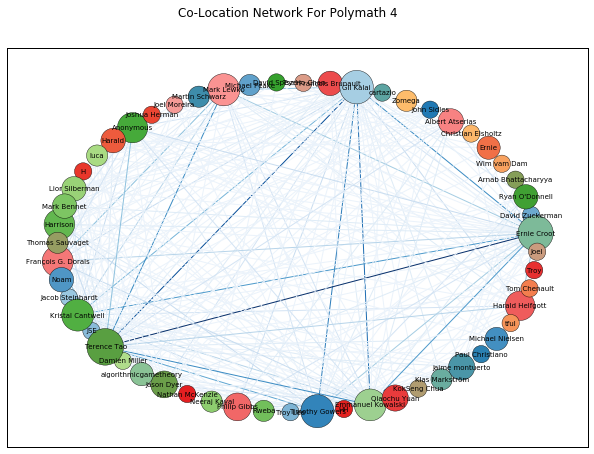

In [26]:
draw_network("Polymath 4", graph_type="cluster")

+ Weighted undirected graph.
+ Edges indicate co-presence in an episode.
+ Weight of edges (intensity) indicates repeated co-presence.

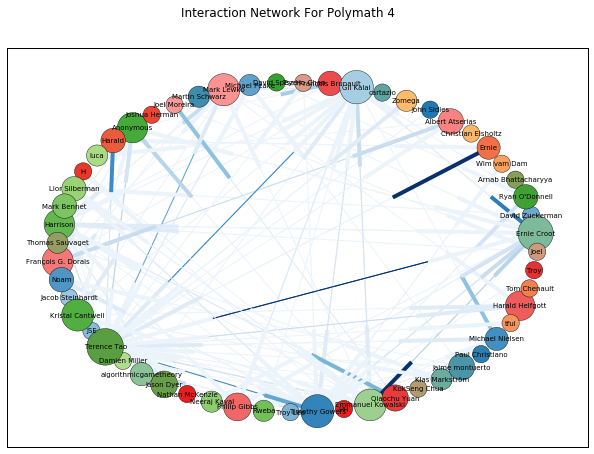

In [27]:
draw_network("Polymath 4", graph_type="interaction")

In [28]:
pm4_i = get_project_at("Polymath 4", -1).network.i_graph
pm4_c = get_project_at("Polymath 4", -1).network.c_graph

In [29]:
print("Density of co-location network: ", nx.density(pm4_c))
print("Density of interaction network: ", nx.density(pm4_i))

Density of co-location network:  0.18506493506493507
Density of interaction network:  0.05357142857142857


## Evaluation

### Proposal 1: Centre of Discussion
+ Valuable metaphor.
+ Inherent vagueness: how far does the centre of discussion reach?
+ Not flexible: size of the centre of discussion can change over time.
+ Compatible with one-to-many communications.

### Proposal 2: Co-presence in episodes
+ Precise bounds: episodes are exclusive and exhaustive.
+ Flexible: length of episodes depends on commenting-activity.
+ Unknowable: episodes can only be identified after the fact.
+ Co-location network based on co-presence in an episode privileges binary relations between agents.

## The role of leading figures

+ Gowers and Tao are highly connected on all accounts we considered.
+ They are almost constantly present in the centre of discussion.

+ Blog-posts can be treated as public announcements.

+ All participants can make public announcements to the group in the centre of discussion (or active in the current episode).

+ Because presence in the centre of discussion is commonly known, the availability of leading figures is commonly known as well.

+ Trust in central figures and common knowledge of their availability ensures successful aggregation, understood as further pursuing what seems promising and abandoning likely dead-ends. 

## Concluding remarks
+ Polymath as a community that was crowdsourced at the early stages of Polymath 1.
+ Effective collaboration through group-attitudes.
+ Active aggregation by central figures that are commonly known to be available.

### Questions?

In [74]:
#TODO: use sizes as node_size
def make_network(ser, network, edge_list):
    edge_dict = {(i,j): k for (i,j,k) in edge_list}
    df = DataFrame(index=ser.index, columns=ser.index)
    for (i,j) in edge_dict.keys():
        df[i][j] = edge_dict[(i,j)]
    df = df.fillna(0)
    network.add_nodes_from(ser.index)
    network.add_weighted_edges_from(edge_list)
    return network,df

def digraph_from_series_of_sets(ser):
    network = nx.DiGraph()
    edge_list = [(i, j, (len(ser[i] & ser[j]) / len(ser[i]))) for (i, j) in permutations(ser.index, 2)]
    return make_network(ser, network, edge_list)
    
def graph_from_series_of_sets(ser):
    network = nx.Graph()
    edge_list = [(i, j, (len(ser[i] & ser[j]) / len(ser[i] | ser[j]))) for (i, j) in combinations(ser.index, 2)]
    #edge_list = [(i, j, (len(ser[i] & ser[j]))) for (i, j) in combinations(ser.index, 2)]
    return make_network(ser, network, edge_list)
    


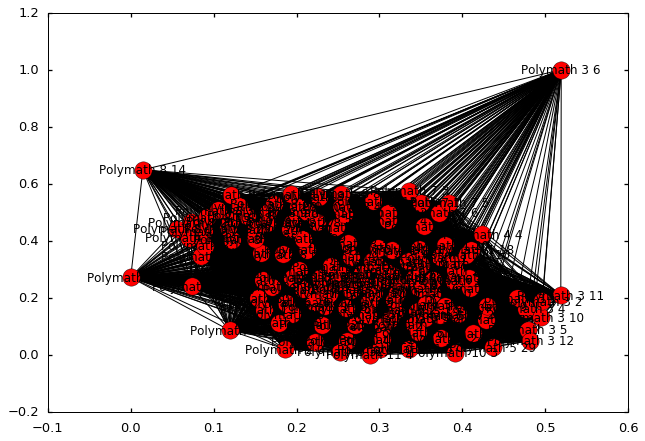

In [62]:
thread_ser = PM_FRAME['authors'].copy()
thread_ser.index = [project + " " + str(i) for (project, i) in thread_ser.index.values]
a_netw, a_df = graph_from_series_of_sets(thread_ser)
nx.draw_networkx(a_netw)

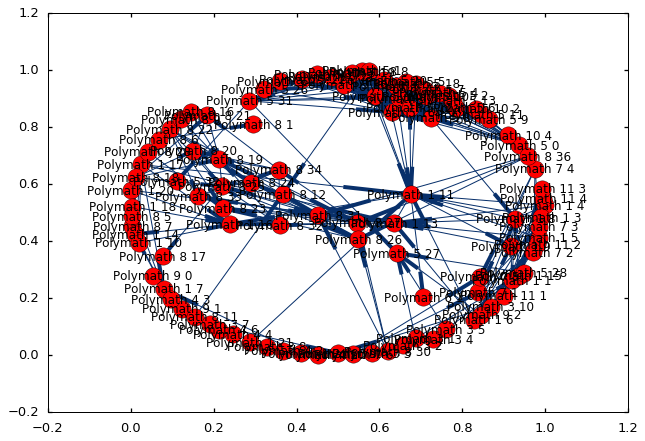

In [68]:
a_netw = nx.DiGraph([(u,v,d) for u,v,d in a_netw.edges(data=True) if d['weight'] >= .33])
a_netw_edges = a_netw.edges()
a_netw_weights = [a_netw[source][dest]['weight'] for source, dest in a_netw_edges]
a_netw_colors = [plt.cm.Blues(weight*15) for weight in a_netw_weights]
nx.draw_networkx(a_netw, edges=a_netw_edges, width=1, edge_color=a_netw_colors)

In [53]:
for comp in nx.weakly_connected_components(a_netw):
    if len(comp) > 1:
        for project in sorted(list(comp)):
            print(project)
        print()

Polymath 1 1
Polymath 1 11
Polymath 1 12
Polymath 1 13
Polymath 1 15
Polymath 1 16
Polymath 1 2
Polymath 1 3
Polymath 1 4
Polymath 1 5
Polymath 1 8
Polymath 1 9
Polymath 10 0
Polymath 10 1
Polymath 10 2
Polymath 10 3
Polymath 10 4
Polymath 11 0
Polymath 11 1
Polymath 11 2
Polymath 11 3
Polymath 11 4
Polymath 3 0
Polymath 3 1
Polymath 3 11
Polymath 3 2
Polymath 3 3
Polymath 3 4
Polymath 3 5
Polymath 3 7
Polymath 3 8
Polymath 3 9
Polymath 4 0
Polymath 4 1
Polymath 4 2
Polymath 4 3
Polymath 4 5
Polymath 4 6
Polymath 5 0
Polymath 5 1
Polymath 5 10
Polymath 5 11
Polymath 5 12
Polymath 5 13
Polymath 5 14
Polymath 5 15
Polymath 5 16
Polymath 5 17
Polymath 5 18
Polymath 5 19
Polymath 5 2
Polymath 5 20
Polymath 5 21
Polymath 5 22
Polymath 5 23
Polymath 5 27
Polymath 5 28
Polymath 5 3
Polymath 5 31
Polymath 5 33
Polymath 5 4
Polymath 5 5
Polymath 5 6
Polymath 5 7
Polymath 5 9
Polymath 6 1
Polymath 9 2

Polymath 7 0
Polymath 7 1
Polymath 7 2
Polymath 7 3
Polymath 7 4
Polymath 7 5
Polymath 7 6

Po

Project      Polymath 1  Polymath 2  Polymath 3  Polymath 4  Polymath 5  \
Project                                                                   
Polymath 1     0.000000    0.000000    0.000000    0.000000    0.000000   
Polymath 2     0.027273    0.000000    0.000000    0.000000    0.000000   
Polymath 3     0.062500    0.018868    0.000000    0.000000    0.000000   
Polymath 4     0.140845    0.032787    0.095745    0.000000    0.000000   
Polymath 5     0.127389    0.026316    0.082569    0.114035    0.000000   
Polymath 6     0.062500    0.052632    0.090909    0.078125    0.090909   
Polymath 7     0.031496    0.000000    0.043478    0.051948    0.032258   
Polymath 8     0.055351    0.005376    0.027149    0.063063    0.050209   
Polymath 9     0.049587    0.037037    0.079365    0.084507    0.069767   
Polymath 10    0.037313    0.025641    0.081081    0.085366    0.050505   
Polymath 11    0.027586    0.063830    0.046512    0.053191    0.055556   

Project      Polymath 6  Polymath 7  Polymath 8  Polymath 9  Polymath 10  \
Project                                                                    
Polymath 1     0.000000    0.000000    0.000000    0.000000     0.000000   
Polymath 2     0.000000    0.000000    0.000000    0.000000     0.000000   
Polymath 3     0.000000    0.000000    0.000000    0.000000     0.000000   
Polymath 4     0.000000    0.000000    0.000000    0.000000     0.000000   
Polymath 5     0.000000    0.000000    0.000000    0.000000     0.000000   
Polymath 6     0.000000    0.000000    0.000000    0.000000     0.000000   
Polymath 7     0.055556    0.000000    0.000000    0.000000     0.000000   
Polymath 8     0.026596    0.030151    0.000000    0.000000     0.000000   
Polymath 9     0.096774    0.095238    0.036082    0.000000     0.000000   
Polymath 10    0.121951    0.054545    0.028986    0.102041     0.000000   
Polymath 11    0.056604    0.030303    0.032407    0.103448     0.085714   

Project      Polymath 11  
Project                   
Polymath 1             0  
Polymath 2             0  
Polymath 3             0  
Polymath 4             0  
Polymath 5             0  
Polymath 6             0  
Polymath 7             0  
Polymath 8             0  
Polymath 9             0  
Polymath 10            0  
Polymath 11            0

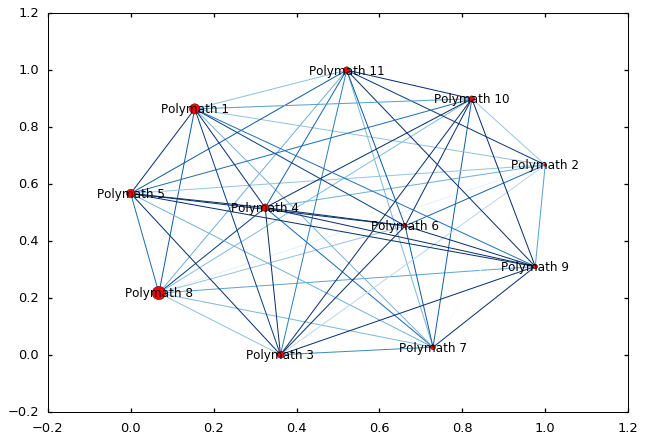

In [86]:
project_ser = get_last(POLYMATHS)[0]['authors (accumulated)']
project_network, project_matrix = graph_from_series_of_sets(project_ser)
project_nodes, project_sizes = project_ser.index.tolist(), project_ser.apply(len).tolist()
project_edges = project_network.edges()
project_weights = [project_network[source][dest]['weight']  for source, dest in project_edges]
project_colors = [plt.cm.Blues(weight*15) for weight in project_weights]
nx.draw_networkx(project_network, nodelist=project_nodes, node_size=project_sizes, edges=project_edges, width=1, edge_color=project_colors)
project_matrix

In [85]:
project_nodes.tolist()

['Polymath 1',
 'Polymath 2',
 'Polymath 3',
 'Polymath 4',
 'Polymath 5',
 'Polymath 6',
 'Polymath 7',
 'Polymath 8',
 'Polymath 9',
 'Polymath 10',
 'Polymath 11']

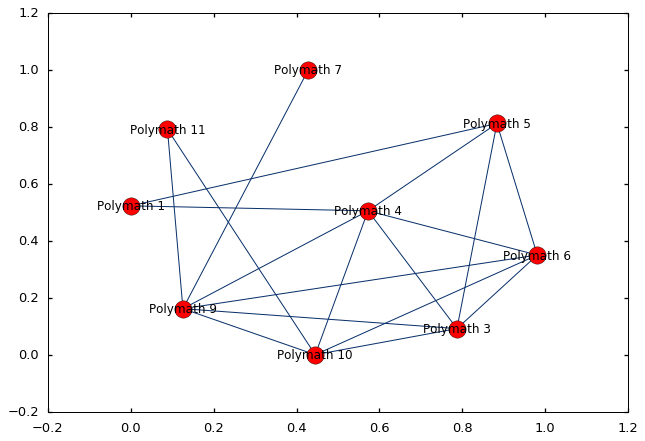

In [71]:
f_project_network = nx.Graph([(u,v,d) for u,v,d in project_network.edges(data=True) if d['weight'] >= .075])
f_project_edges = f_project_network.edges()
f_project_weights = [f_project_network[source][dest]['weight']  for source, dest in f_project_edges]
f_project_colors = [plt.cm.Blues(weight*15) for weight in f_project_weights]
nx.draw_networkx(f_project_network, edges=f_project_edges, width=1, edge_color=f_project_colors)

In [34]:
DataFrame.from_records([(1,2,3), (2,1,4)])


0  1  2
0  1  2  3
1  2  1  4